<a href="https://colab.research.google.com/github/SeongminCC/private_project/blob/main/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARIMA(Autoregressive Integrated Moving Average)

**전통적인 시계열 예측 방법 2가지**
- 자기 자신의 과거를 정보로 사용
  - 이전의 상태를 참고하여 현재의 상태를 계산
- 이전 항에서의 오차를 이용하여 현재 항의 상태를 추론

**이 둘을 합친 것이 ARMA모델이며 추세 변동의 경향성을 반영한 것이 ARIMA모델**

**ARIMA**
- AR : 자기회귀(Autoregression). 이전 관측값의 오차항이 이후 관측값에 영향을 주는 모형

- I : Intgrated : 누적을 의미, 차분을 이용하는 시계열 모형들에 붙이는 표현

- MA : 이동평균(Moving Average). 관측값이 이전의 연속적인 오차항의 영향을 받는 다는 모형

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm
import warnings
from glob import glob
from sklearn.model_selection import train_test_split
import random
import os

# 경고 끄기
warnings.filterwarnings(action='ignore')

# 시드고정
random.seed(19970119)
np.random.seed(19970119)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/private project
!ls -al

/content/drive/MyDrive/private project
total 7
-rw------- 1 root root 2417 Sep  9 15:21 ARIMA.ipynb
drwx------ 3 root root 4096 Sep  9 15:14 data


# 데이터 불러오기
**2021/09/09 ~ 2022/09/09 까지의 비트코인 가격(USD) 데이터인 csv파일을 불러온다**

In [ ]:
bitcoin_df = pd.read_csv('./data/bitcoin/bitcoin_20210909_20220909.csv')
bitcoin_df

,Timestamp,market-price
0,2021-09-09 00:00:00,46078.38
1,2021-09-10 00:00:00,46368.69
2,2021-09-11 00:00:00,44847.48
3,2021-09-12 00:00:00,45144.79
4,2021-09-13 00:00:00,46059.12
...,...,...
361,2022-09-05 00:00:00,19994.65
362,2022-09-06 00:00:00,19789.87
363,2022-09-07 00:00:00,18806.70
364,2022-09-08 00:00:00,19280.08


**데이터 전처리**

In [ ]:
day_split = bitcoin_df['Timestamp'].str.split(" ")

In [ ]:
bitcoin_df['Timestamp'] = day_split.str.get(0)
bitcoin_df.columns = ['datadate', 'price']
bitcoin_df

,datadate,price
0,2021-09-09,46078.38
1,2021-09-10,46368.69
2,2021-09-11,44847.48
3,2021-09-12,45144.79
4,2021-09-13,46059.12
...,...,...
361,2022-09-05,19994.65
362,2022-09-06,19789.87
363,2022-09-07,18806.70
364,2022-09-08,19280.08


**시계열 정보를 데이터 프레임의 인덱스로 설정**

In [ ]:
bitcoin_df['datadate'] = pd.to_datetime(bitcoin_df['datadate'])
bitcoin_df.index = bitcoin_df['datadate']
bitcoin_df.set_index('datadate', inplace=True)
bitcoin_df

,price
datadate,
2021-09-09,46078.38
2021-09-10,46368.69
2021-09-11,44847.48
2021-09-12,45144.79
2021-09-13,46059.12
...,...
2022-09-05,19994.65
2022-09-06,19789.87
2022-09-07,18806.70


# train / test 데이터셋 나누기

In [ ]:
bitcoin_df_train = bitcoin_df.iloc[:-5]
bitcoin_df_test = bitcoin_df.iloc[-5:]
bitcoin_df_test

,price
datadate,
2022-09-05,19994.65
2022-09-06,19789.87
2022-09-07,18806.70
2022-09-08,19280.08
2022-09-09,19327.53


# 가격 추이 시각화

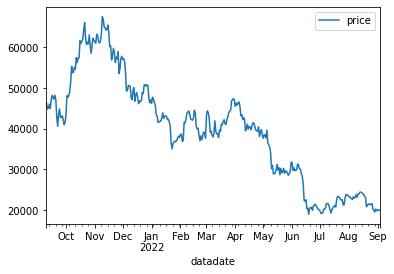

In [ ]:
bitcoin_df_train.plot()
plt.show()

# ARIMA 분석

현재에 존재하는 시계열자료는 불안정(Non-stationary)한 경우가 많음 -> 기존의 모델(ARMA 등)으로 이러한 경우를 설명하는 것이 어려움

**모델 그 자체에 비정상성을 제거하는 과정이 포함된 ARIMA를 사용하는 것이 합리적임**
  - 보통 ARIMA(p,d,q)로 표현

**ARIMA의 클래스 order=(p,d,q)**
  - p : AR이 몇 번째 과거까지를 바라보는가
  - d : 차분에 대한 파라미터
  - q : MA가 몇 번째 과거까지를 바라보는가

    - 차분 : 현재 상태의 변수에서 바로 전 상태의 변수를 빼주는 것을 의미

         (시계열 데이터의 불규칙성을 조금이나마 보정해주는 역할)

**파라미터 p,d,q는 가이드라인이 존재함**
  - 좋은 파라미터의 조합
    - p와 q의 합이 2 미만인 경우
    - p와 q의 곱이 0을 포함한 짝수인 경우


In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

model = ARIMA(bitcoin_df_train.price.values, order=(2,1,2))
model_fit = model.fit(trend='c', full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  360
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3121.076
Method:                       css-mle   S.D. of innovations           1402.118
Date:                Fri, 09 Sep 2022   AIC                           6254.152
Time:                        16:32:03   BIC                           6277.468
Sample:                             1   HQIC                          6263.423
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -72.8935     73.473     -0.992      0.321    -216.897      71.110
ar.L1.D.y      0.3677      0.009     38.912      0.000       0.349       0.386
ar.L2.D.y     -0.9974      0.005   -218.508      0.0

**예측한 결과 시각화**

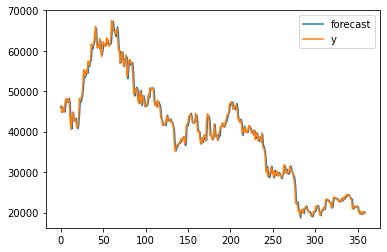

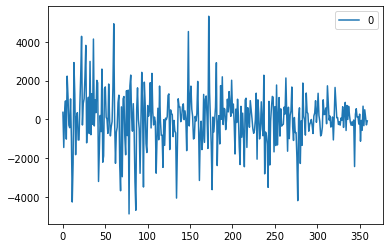

In [ ]:
# 학습 데이터에 대한 예측 결과 (첫 번째 그래프)
fig = model_fit.plot_predict()

# 잔차의 변동을 시각화 (두번 째 그래프)
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

급격한 하락세에 대한 데이터이기 때문에 잔차에 대한 그래프의 폭이 불규칙함을 볼 수 있음
  - 폭이 일정해야 실제값과 예측값 사이의 오차 변동이 적은 것 
    - 폭이 일정하면 좋은 예측 모델을 학습시킨 것

# ARIMA 모델 평가 : 실제 데이터와 비교

1. model_fit.forecast(steps=5) : 향후 5일의 가격을 예측하여 pred_y로 정의
2. test 데이터에서 실제 향후 5일의 가격을 test_y로 정의
3. 모델이 예측한 상한값, 하한값을 pred_y_upper, pred_y_lower로 정의
4. 정의한 모든 값을 비교하여 5일 동안의 상승 경향 예측이 얼마나 맞았는지 평가

In [ ]:
forecast_data = model_fit.forecast(steps=5)  # 향후 5일 뒤의 데이터 예측

bitcoin_df_test['ds'] = bitcoin_df_test.index
bitcoin_df_test.columns = ['ds', 'y']
bitcoin_df_test=bitcoin_df_test.reset_index(drop=True)

# columns 순서 변경
bitcoin_df_test = bitcoin_df_test[['y', 'ds']]
bitcoin_df_test.columns = ['ds', 'y']
bitcoin_df_test

,ds,y
0,2022-09-05,19994.65
1,2022-09-06,19789.87
2,2022-09-07,18806.70
3,2022-09-08,19280.08
4,2022-09-09,19327.53


In [ ]:
forecast_data

(array([19597.29027695, 19430.95897944, 19488.03796704, 19556.12213714,
        19405.42689491]),
 array([1402.11750773, 1970.97754424, 2407.59803238, 2784.34750623,
        3119.64719996]),
 array([[16849.19045971, 22345.3900942 ],
        [15567.9139784 , 23294.00398048],
        [14769.23253432, 24206.84339975],
        [14098.90130448, 25013.3429698 ],
        [13291.03073851, 25519.82305131]]))

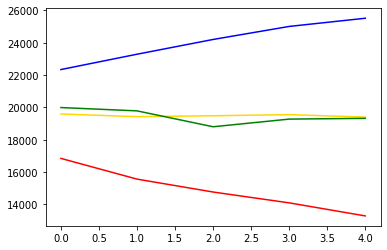

In [ ]:
pred_y = forecast_data[0].tolist()  # 마지막 5일의 예측 데이터
test_y = bitcoin_df_test.y.values  # 실제 5일 가격 데이터

pred_y_lower = []  # 마지막 5일의 예측 데이터의 최소값
pred_y_upper = []  # 마지막 5일의 예측 데이터의 최대값

for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

plt.plot(pred_y, color='gold')  # 모델이 예측한 가격 그래프
plt.plot(pred_y_lower, color = 'red')  # 모델이 예측한 최저 가격 그래프
plt.plot(pred_y_upper, color = 'blue')  # 모델이 예측한 최고 가격 그래프
plt.plot(test_y, color = 'green')  # 실제 가격 그래프

- 파란색 : 모델이 예상한 최고 가격
- 초록색 : 실제 5일 간의 가격
- 노란색 : 모델이 예측한 5일 간의 가격
- 빨간색 : 모델이 예상한 최소 가격

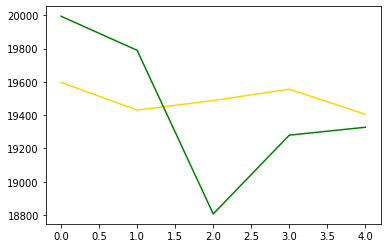

In [ ]:
plt.plot(pred_y, color='gold')  # 모델이 예측한 가격 그래프
plt.plot(test_y, color = 'green')  # 실제 가격 그래프

In [ ]:
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
import math

In [ ]:
rmse = math.sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

408.2157476674882
